In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict

awkward version  1.10.1
coffea version  0.7.19


In [2]:
def find_closest( a, coll , verbose = False):
        combs = ak.cartesian( (a, coll), axis=1 )
        dr = combs['0'].delta_r(combs['1'])
        dr_min = ak.singletons( ak.argmin( dr, axis=1 ) )
        sel = combs[dr_min]['1']
        if verbose: 
            print("a eta ", a.eta)
            print("a phi ", a.phi)
            print("coll eta ", coll.eta)
            print("coll phi ", coll.phi)
            print("dr ", dr)
            print("dr_min ", dr_min)
            print("sel ", ak.firsts(sel))
        return ak.firsts(sel),ak.firsts(dr[dr_min])

In [3]:
def find_opposite( a, coll, dphimin = 1, verbose=False ):
        if verbose:
            print("a pt ", a.pt)
            print("a phi ", a.phi)
            print("coll pt : ", coll.pt)
            print("coll phi : ", coll.phi)
        combs = ak.cartesian( (a, coll), axis=1 )
        dphi = np.abs(combs['0'].delta_phi(combs['1']))
        sel = dphi > dphimin
        coll_opposite = combs[ sel ]
        if verbose: 
            print('combs pt0 ', combs['0'].pt)
            print('combs pt1 ', combs['1'].pt)
            print('combs phi0', combs['0'].phi)
            print('combs phi1', combs['1'].phi)
            print('dphi ', dphi)
            print("coll_opposite pt ", coll_opposite['1'].pt )
            print("coll_opposite phi ", coll_opposite['1'].phi )            

        return ak.firsts( coll_opposite['1'] ), sel

In [4]:
def find_closest_subjets( a, coll, verbose=False ):
        combs = ak.cartesian( (a, coll), axis=1 )
        dr = combs['0'].delta_r(combs['1'])
        sel = (dr < 0.8)
        combs = ( combs[sel] )
        nsubjet = ak.num( combs['1'], axis=1)
        sel2 = (nsubjet==2)
        combs = (combs[sel2])
        retval = ak.singletons( combs['1'][:,0] + combs['1'][:,1] )
        if verbose: 
            print(" n subjet : ", ak.num(coll, axis=1))
            print("jet pt    : ", a.pt)
            print("jet eta   : ", a.eta)
            print("jet phi   : ", a.phi)
            print("jet m     : ", a.mass)
            print("return pt : ", retval.pt)
            print("return eta: ", retval.eta)
            print("return phi: ", retval.phi)
            print("return m  : ", retval.mass)
        return retval

In [5]:
class QJetMassProcessor(processor.ProcessorABC):
    def __init__(self, ptcut=200., etacut = 2.5, ptcut_ee = 40., ptcut_mm = 29.):
        # should have separate lower ptcut for gen
        self.ptcut = ptcut
        self.etacut = etacut        
        self.lepptcuts = [ptcut_ee, ptcut_mm]
        
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        lep_axis = hist.axis.StrCategory(["ee", "mm"], name="lep")
        n_axis = hist.axis.Regular(5, 0, 5, name="n", label=r"Number")
        mass_axis = hist.axis.Regular(100, 0, 1000, name="mass", label=r"$m$ [GeV]")
        zmass_axis = hist.axis.Regular(100, 80, 100, name="mass", label=r"$m$ [GeV]")
        pt_axis = hist.axis.Regular(150, 0, 1500, name="pt", label=r"$p_{T}$ [GeV]")                
        frac_axis = hist.axis.Regular(150, 0, 2.0, name="frac", label=r"Fraction")                
        dr_axis = hist.axis.Regular(150, 0, 6.0, name="dr", label=r"$\Delta R$")
        dr_fine_axis = hist.axis.Regular(150, 0, 1.5, name="dr", label=r"$\Delta R$")
        dphi_axis = hist.axis.Regular(150, -2*np.pi, 2*np.pi, name="dphi", label=r"$\Delta \phi$")
        h_njet_gen = hist.Hist(dataset_axis, lep_axis, n_axis, storage="weight", label="Counts")
        h_njet_reco = hist.Hist(dataset_axis, lep_axis, n_axis, storage="weight", label="Counts")
        h_ptjet_gen = hist.Hist(dataset_axis, lep_axis, pt_axis, storage="weight", label="Counts")
        h_ptjet_reco = hist.Hist(dataset_axis, lep_axis, pt_axis, storage="weight", label="Counts")
        h_ptjet_reco_over_gen = hist.Hist(dataset_axis, lep_axis, frac_axis, storage="weight", label="Counts")
        h_drjet_reco_gen = hist.Hist(dataset_axis, lep_axis, dr_fine_axis, storage="weight", label="Counts")
        h_mz_gen = hist.Hist(dataset_axis, lep_axis, zmass_axis, storage="weight", label="Counts")
        h_mz_reco = hist.Hist(dataset_axis, lep_axis, zmass_axis, storage="weight", label="Counts")
        h_mz_reco_over_gen = hist.Hist(dataset_axis, lep_axis, frac_axis, storage="weight", label="Counts")
        h_dr_z_jet_gen = hist.Hist(dataset_axis, lep_axis, dr_axis, storage="weight", label="Counts")
        h_dr_z_jet_reco = hist.Hist(dataset_axis, lep_axis, dr_axis, storage="weight", label="Counts")
        h_dphi_z_jet_gen = hist.Hist(dataset_axis, lep_axis, dphi_axis, storage="weight", label="Counts")
        h_dphi_z_jet_reco = hist.Hist(dataset_axis, lep_axis, dphi_axis, storage="weight", label="Counts")
        h_ptasym_z_jet_gen = hist.Hist(dataset_axis, lep_axis, frac_axis, storage="weight", label="Counts")
        h_ptasym_z_jet_reco = hist.Hist(dataset_axis, lep_axis, frac_axis, storage="weight", label="Counts")
        
        h_mjet_reco_over_gen = hist.Hist(dataset_axis, lep_axis, frac_axis, storage="weight", label="Counts")
        
        cutflow = {}
        
        self.hists = {
            "njet_gen":h_njet_gen,
            "njet_reco":h_njet_reco,
            "ptjet_gen":h_ptjet_gen, 
            "ptjet_reco":h_ptjet_reco, 
            "ptjet_reco_over_gen":h_ptjet_reco_over_gen,
            "drjet_reco_gen":h_drjet_reco_gen,
            "mz_gen":h_mz_gen,
            "mz_reco":h_mz_reco,
            "mz_reco_over_gen":h_mz_reco_over_gen,
            "dr_z_jet_gen":h_dr_z_jet_gen,
            "dr_z_jet_reco":h_dr_z_jet_reco,            
            "dphi_z_jet_gen":h_dphi_z_jet_gen,
            "dphi_z_jet_reco":h_dphi_z_jet_reco,
            "ptasym_z_jet_gen":h_ptasym_z_jet_gen,
            "ptasym_z_jet_reco":h_ptasym_z_jet_reco,
            "mjet_reco_over_gen":h_mjet_reco_over_gen,
            "cutflow":cutflow
        }
    
    @property
    def accumulator(self):
        return self._histos

    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        dataset = events.metadata['dataset']
        
        if dataset not in self.hists["cutflow"]:
            self.hists["cutflow"][dataset] = defaultdict(int)

        genelectrons = events.GenDressedLepton[ np.abs(events.GenDressedLepton.pdgId) == 11]
        genmuons = events.GenDressedLepton[ np.abs(events.GenDressedLepton.pdgId) == 13]        
        genleptons = [genelectrons, genmuons]    
        recoleptons = [events.Electron, events.Muon]
        
        
        for ilep,lepstr in dict(zip( [0,1], ["ee", "mm"] )).items():
            
            weights = events["LHEWeight"].originalXWGTUP
            #####################################
            # Gen lepton and Z selection
            #####################################
            self.hists["cutflow"][dataset][lepstr + " total"] += len(genleptons[ilep])
            
            genlepsel = (genleptons[ilep].pt > self.lepptcuts[ilep]) & (np.abs(genleptons[ilep].eta) < 2.5)
            genleptons[ilep] = genleptons[ilep][ genlepsel ]            
            nlep=ak.num(genleptons[ilep])
            isDilepGen = (nlep >= 2)
            self.hists["cutflow"][dataset][lepstr + " nlep >=2"] += len(isDilepGen)
            weights = weights[isDilepGen]
            genleptons[ilep] = genleptons[ilep][isDilepGen]
            z_gen = genleptons[ilep][:,0] + genleptons[ilep][:,1]
            z_gen_ptsel = z_gen.pt > 90.
            z_gen = z_gen[ z_gen_ptsel ]
            self.hists["cutflow"][dataset][lepstr + " zpt > 90"] += len(z_gen_ptsel)            
            weights = weights[ z_gen_ptsel ]
            
            self.hists["njet_gen"].fill(dataset=dataset,
                                        lep=lepstr, 
                                        n=ak.num(events[isDilepGen][z_gen_ptsel].GenJetAK8),
                                        weight = weights )
            n_gen_jet_sel = ak.num( events[isDilepGen][z_gen_ptsel].GenJetAK8,axis=1 ) > 0
            
            

            
            #####################################
            # Gen jet selection
            #####################################
            
            # Find highest pt jet that is at least 1 radian in phi from the Z
            z_gen = z_gen[n_gen_jet_sel]
            gen_jet, gen_jet_found_sel = find_opposite( z_gen, events[isDilepGen][z_gen_ptsel][n_gen_jet_sel].GenJetAK8)
            gen_jet_n = np.logical_not( ak.is_none(gen_jet) )
            gen_jet = gen_jet[gen_jet_n]
            z_gen = z_gen[gen_jet_n]
            weights = weights[gen_jet_n]
            self.hists["mz_gen"].fill(dataset=dataset,lep=lepstr, mass=z_gen.mass,weight=weights)
            self.hists["cutflow"][dataset][lepstr + " >=1 gen jet"] += len(gen_jet_n)
            
            gen_jet_ptsel = gen_jet.pt > 170.
            gen_jet_etasel = np.abs(gen_jet.eta) < 2.5
            z_dphi_gen = z_gen.delta_phi( gen_jet )
            z_dphi_gen_sel = np.abs(z_dphi_gen) > np.pi * 0.5
            z_pt_asym_gen = np.abs(z_gen.pt - gen_jet.pt) / (z_gen.pt + gen_jet.pt)
            z_pt_asym_gen_sel = z_pt_asym_gen < 0.3

            self.hists["dphi_z_jet_gen"].fill(dataset=dataset,lep=lepstr, dphi=z_dphi_gen,weight=weights)
            self.hists["ptasym_z_jet_gen"].fill(dataset=dataset,lep=lepstr, frac=z_pt_asym_gen,weight=weights)
            
            gen_jet_sel = gen_jet_ptsel & gen_jet_etasel & z_dphi_gen_sel & z_pt_asym_gen_sel
            weights = weights[gen_jet_sel]
            gen_jet = gen_jet[gen_jet_sel]
            z_gen = z_gen[gen_jet_sel]
            self.hists["cutflow"][dataset][lepstr + " gen jet cuts"] += len(gen_jet_sel)
            self.hists["ptjet_gen"].fill(dataset=dataset,lep=lepstr, pt=gen_jet.pt, weight=weights)

            #####################################
            # Reco lepton and Z selection
            #####################################
            self.hists["cutflow"][dataset][lepstr + " total"] += len(genleptons[ilep])
            recoleptons[ilep] = recoleptons[ilep][isDilepGen][z_gen_ptsel][n_gen_jet_sel][gen_jet_n][gen_jet_sel]

            recolepsel = (recoleptons[ilep].pt > self.lepptcuts[ilep]) & (np.abs(recoleptons[ilep].eta) < 2.5)
            recoleptons[ilep] = recoleptons[ilep][ recolepsel ]            
            nlep=ak.num(recoleptons[ilep])
            isDilepReco = (nlep >= 2)
            gen_jet = gen_jet[isDilepReco]
            z_gen = z_gen[isDilepReco]
            weights = weights[isDilepReco]
            self.hists["cutflow"][dataset][lepstr + " nlep >=2"] += len(isDilepReco)

            
            recoleptons[ilep] = recoleptons[ilep][isDilepReco]
            z_reco = recoleptons[ilep][:,0] + recoleptons[ilep][:,1]
            z_reco_ptsel = z_reco.pt > 90.
            z_reco = z_reco[ z_reco_ptsel ]
            gen_jet = gen_jet[ z_reco_ptsel ]
            z_gen = z_gen[ z_reco_ptsel ]
            weights = weights[z_reco_ptsel]
            self.hists["dr_z_jet_gen"].fill( dataset=dataset,lep=lepstr,dr=z_gen.delta_r(gen_jet), weight=weights )
            self.hists["cutflow"][dataset][lepstr + " zpt > 90"] += len(z_reco_ptsel)
            


            #####################################
            # Reco jet selection
            #####################################
            recojets = events[isDilepGen][z_gen_ptsel][n_gen_jet_sel][gen_jet_n][gen_jet_sel][isDilepReco][z_reco_ptsel].FatJet

            #print("gen jets pt  ", gen_jet.pt )
            #print("recojets pt  ", recojets.pt )
            #print("gen jets eta ", gen_jet.eta )
            #print("recojets eta ", recojets.eta )
            #print("gen jets phi ", gen_jet.phi )
            #print("recojets phi ", recojets.phi )
            
            
            
            self.hists["njet_reco"].fill(dataset=dataset,lep=lepstr, n=ak.num(recojets,axis=1))
            n_reco_jet_sel = ak.num( recojets,axis=1 ) > 0
            
            recojets = recojets[n_reco_jet_sel]
            gen_jet = gen_jet[n_reco_jet_sel]
            z_gen = z_gen[n_reco_jet_sel]
            z_reco = z_reco[n_reco_jet_sel]
            weights = weights[n_reco_jet_sel]
            
            # Find reco jet closest to the gen jet
            reco_jet,reco_jet_dr = find_closest( gen_jet, recojets, verbose=False)
            
            #print("reco_jet_dr ", reco_jet_dr)
            
            #print("gen_jet ", gen_jet.pt)
            #print("reco_jet ", reco_jet.pt)


            
            reco_jet_n = np.logical_not( ak.is_none(reco_jet) ) & (reco_jet_dr < 0.4)
            gen_jet = gen_jet[reco_jet_n]
            reco_jet = reco_jet[reco_jet_n]
            z_reco = z_reco[reco_jet_n]
            z_gen = z_gen[reco_jet_n]
            weights = weights[reco_jet_n]
            self.hists["mz_reco"].fill(dataset=dataset,lep=lepstr, mass=z_reco.mass, weight=weights)
            self.hists["mz_reco_over_gen"].fill(dataset=dataset,lep=lepstr, frac=z_reco.mass / z_gen.mass, weight=weights )
            self.hists["cutflow"][dataset][lepstr + " >=1 reco jet"] += len(reco_jet_n)
            
            reco_jet_ptsel = reco_jet.pt > 170.
            reco_jet_etasel = np.abs(reco_jet.eta) < 2.5
            z_dphi_reco = z_reco.delta_phi( reco_jet )
            z_dphi_reco_sel = np.abs(z_dphi_reco) > np.pi * 0.5
            z_pt_asym_reco = np.abs(z_reco.pt - reco_jet.pt) / (z_reco.pt + reco_jet.pt)
            z_pt_asym_reco_sel = z_pt_asym_reco < 0.3
            #print("z_pt_asym_reco ", z_pt_asym_reco)
            #print("z_dphi_reco ", z_dphi_reco)
            self.hists["dr_z_jet_reco"].fill( dataset=dataset,lep=lepstr,dr=z_reco.delta_r(reco_jet), weight=weights )
            self.hists["dphi_z_jet_reco"].fill(dataset=dataset,lep=lepstr, dphi=z_dphi_reco, weight=weights)
            self.hists["ptasym_z_jet_reco"].fill(dataset=dataset,lep=lepstr, frac=z_pt_asym_reco, weight=weights)
            reco_jet_sel = reco_jet_ptsel & reco_jet_etasel & z_dphi_reco_sel & z_pt_asym_reco_sel
            reco_jet = reco_jet[reco_jet_sel]
            z_reco = z_reco[reco_jet_sel]
            gen_jet = gen_jet[reco_jet_sel]
            weights = weights[reco_jet_sel]
            #print("gen_jet eta", gen_jet.eta)
            #print("reco_jet eta", reco_jet.eta)
            #print("gen_jet phi", gen_jet.phi)
            #print("reco_jet phi", reco_jet.phi)
            
            self.hists["cutflow"][dataset][lepstr + " reco jet cuts"] += len(reco_jet_sel)
            self.hists["drjet_reco_gen"].fill(dataset=dataset,lep=lepstr, dr=reco_jet.delta_r(gen_jet), weight=weights)
            self.hists["ptjet_reco"].fill(dataset=dataset,lep=lepstr, pt=reco_jet.pt, weight=weights)
            self.hists["ptjet_reco_over_gen"].fill(dataset=dataset,lep=lepstr, frac=reco_jet.pt/gen_jet.pt, weight=weights)
            
            
            # Now get groomed jets from the subjets
            selevents = events[isDilepGen][z_gen_ptsel][n_gen_jet_sel][gen_jet_n][gen_jet_sel][isDilepReco][z_reco_ptsel][n_reco_jet_sel][reco_jet_n][reco_jet_sel]
            #print("selevents ", len(selevents))
            #print("weights ", len(weights))
            #print(" top  level ngenjet = ", ak.num(selevents.GenJetAK8, axis=1))
            #print(" top  level nsubjet = ", ak.num(selevents.SubGenJetAK8, axis=1))
            groomedgenjet = find_closest_subjets(gen_jet, selevents.SubGenJetAK8, False)
            #print("groomedgenjet ", groomedgenjet)
            ngroomedgensel = ak.num( groomedgenjet, axis=1) > 0
            groomedgenjet = ak.firsts(groomedgenjet[ngroomedgensel])
            gen_jet = gen_jet[ngroomedgensel]
            reco_jet = reco_jet[ngroomedgensel]
            weights = weights[ngroomedgensel]
            not_nan = np.logical_not( np.isnan( groomedgenjet.mass ) )
            reco_jet = reco_jet[not_nan]
            gen_jet = gen_jet[not_nan]
            groomedgenjet = groomedgenjet[not_nan]
            weights = weights[not_nan]
            #print("reco_jet.msoftdrop ", reco_jet.msoftdrop)
            #print("groomedgenjet mass ", groomedgenjet.mass)
            
            self.hists["mjet_reco_over_gen"].fill(dataset=dataset,lep=lepstr, frac=reco_jet.msoftdrop/groomedgenjet.mass, weight=weights)
            
            
        return self.hists

    
    def postprocess(self, accumulator):
        return accumulator

In [ ]:
# Can grab a file on cmslpc from 
# /store/group/lpctlbsm/NanoAODJMAR_2019_V1/Production/CRAB/DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8/DYJetsToLLM-50TuneCUETP8M113TeV-madgraphMLM-pythia8RunIISummer16MiniAODv3-PUMoriond17_ext2-v2/190513_171710/0000/*.root
import glob


eras = [
    'UL16NanoAOD', 
    'UL16NanoAODAPV', 
    'UL17NanoAOD', 
    'UL18NanoAOD'
       ]
htbins = ['70to100', '100to200', '200to400', '400to600', '600to800', '800to1200', '1200to2500', '2500toInf']
filestr = '/mnt/data/cms/store/mc/RunIISummer20%sv9/DYJetsToLL_M-50_HT-%s_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/*/*/*.root'
fileset = {}
testing = False

for era in eras: 
    for htbin in htbins : 
        infiles = glob.glob(filestr % (era, htbin) )
        if testing: 
            infiles = infiles[0:2]
        if era not in fileset:
            fileset[era] = []
        else: 
            fileset[era] = fileset[era] + [*infiles]


print("Processing files ")
for era,files in fileset.items():
    print(era)
    for file in files:
        print(file)

Processing files 
UL16NanoAOD
/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/40000/AFAE20D3-ACCA-7048-9AA2-DF46FFC6E18E.root
/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/40000/DC17BD26-FB99-9943-A159-B19C836912AD.root
/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/2430000/64E40ADF-28D3-104F-92F8-2310E0BD7521.root
/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/2430000/13C0D928-E45B-E243-B36C-550AD6D0F26E.root
/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/

In [7]:



tstart = time.time() 

run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=8),
    schema=NanoAODSchema,
    chunksize=10000000,
    #maxchunks=1
)

output = run(
    fileset,
    "Events",
    processor_instance=QJetMassProcessor(),
)


Preprocessing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641/641 [ 0:01:30 < 0:00:00 | 7.0   file/s ]
Merging (local) 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641/641 [ 0:01:30 < 0:00:00 | ?   merges/s ]

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.p

In [8]:
fff = uproot.open(infiles[0])

In [9]:
fff["Events"]

<TTree 'Events' (1628 branches) at 0x7f0a451a9d90>

In [10]:
fff["Events"].keys()

['run',
 'luminosityBlock',
 'event',
 'HTXS_Higgs_pt',
 'HTXS_Higgs_y',
 'HTXS_stage1_1_cat_pTjet25GeV',
 'HTXS_stage1_1_cat_pTjet30GeV',
 'HTXS_stage1_1_fine_cat_pTjet25GeV',
 'HTXS_stage1_1_fine_cat_pTjet30GeV',
 'HTXS_stage1_2_cat_pTjet25GeV',
 'HTXS_stage1_2_cat_pTjet30GeV',
 'HTXS_stage1_2_fine_cat_pTjet25GeV',
 'HTXS_stage1_2_fine_cat_pTjet30GeV',
 'HTXS_stage_0',
 'HTXS_stage_1_pTjet25',
 'HTXS_stage_1_pTjet30',
 'HTXS_njets25',
 'HTXS_njets30',
 'nboostedTau',
 'boostedTau_chargedIso',
 'boostedTau_eta',
 'boostedTau_leadTkDeltaEta',
 'boostedTau_leadTkDeltaPhi',
 'boostedTau_leadTkPtOverTauPt',
 'boostedTau_mass',
 'boostedTau_neutralIso',
 'boostedTau_phi',
 'boostedTau_photonsOutsideSignalCone',
 'boostedTau_pt',
 'boostedTau_puCorr',
 'boostedTau_rawAntiEle2018',
 'boostedTau_rawIso',
 'boostedTau_rawIsodR03',
 'boostedTau_rawMVAnewDM2017v2',
 'boostedTau_rawMVAoldDM2017v2',
 'boostedTau_rawMVAoldDMdR032017v2',
 'boostedTau_charge',
 'boostedTau_decayMode',
 'boostedTau_je

In [11]:
#np.abs(pdgid.array()) == 11

In [12]:
output.keys()

dict_keys(['njet_gen', 'njet_reco', 'ptjet_gen', 'ptjet_reco', 'ptjet_reco_over_gen', 'drjet_reco_gen', 'mz_gen', 'mz_reco', 'mz_reco_over_gen', 'dr_z_jet_gen', 'dr_z_jet_reco', 'dphi_z_jet_gen', 'dphi_z_jet_reco', 'ptasym_z_jet_gen', 'ptasym_z_jet_reco', 'mjet_reco_over_gen', 'cutflow'])

In [13]:
output["cutflow"]

{'UL18NanoAOD': defaultdict(int,
             {'ee total': 81932285,
              'ee nlep >=2': 77083874,
              'ee zpt > 90': 9052007,
              'ee >=1 gen jet': 5215694,
              'ee gen jet cuts': 5141605,
              'ee >=1 reco jet': 1885784,
              'ee reco jet cuts': 1865501,
              'mm total': 85935406,
              'mm nlep >=2': 77416174,
              'mm zpt > 90': 13549062,
              'mm >=1 gen jet': 6556743,
              'mm gen jet cuts': 6402392,
              'mm >=1 reco jet': 2427561,
              'mm reco jet cuts': 2396280}),
 'UL17NanoAOD': defaultdict(int,
             {'ee total': 57092376,
              'ee nlep >=2': 53664096,
              'ee zpt > 90': 6298534,
              'ee >=1 gen jet': 3650769,
              'ee gen jet cuts': 3598642,
              'ee >=1 reco jet': 1295761,
              'ee reco jet cuts': 1283578,
              'mm total': 59873927,
              'mm nlep >=2': 53887825,
             

In [14]:
import matplotlib.pyplot as plt

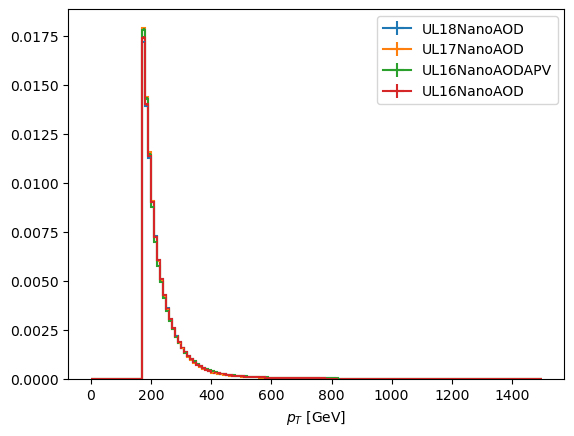

In [15]:
output['ptjet_gen'].stack("dataset").project("pt").plot(density=True)
plt.legend()
plt.show()

In [16]:
output['ptjet_gen'].sum().value

201632.53753881907

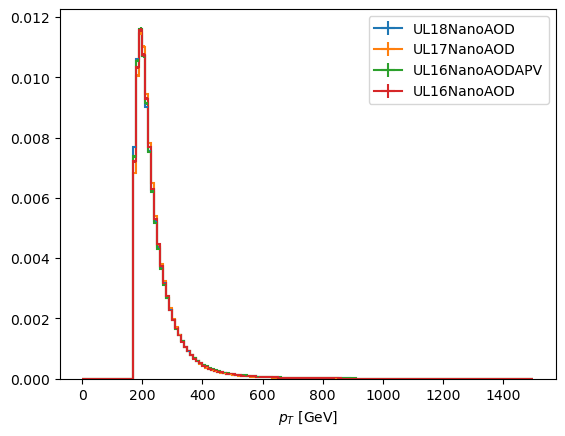

In [17]:
output['ptjet_reco'].stack("dataset").project("pt").plot(density=True)
plt.legend()
plt.show()

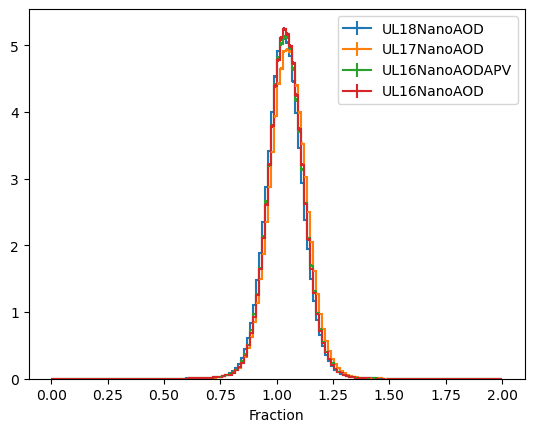

In [18]:
output['ptjet_reco_over_gen'].stack("dataset").project("frac").plot(density=True)
plt.legend()
plt.show()

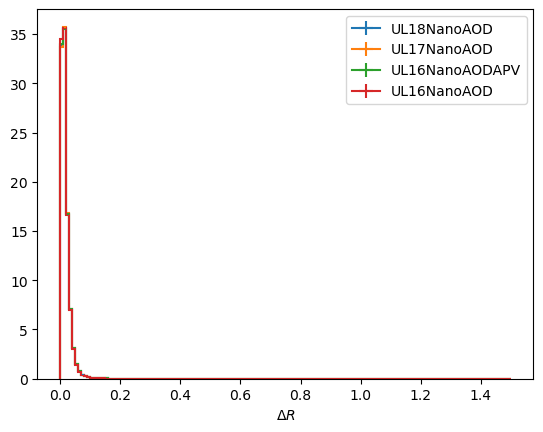

In [19]:
output['drjet_reco_gen'].stack("dataset").project("dr").plot(density=True)
plt.legend()
plt.show()

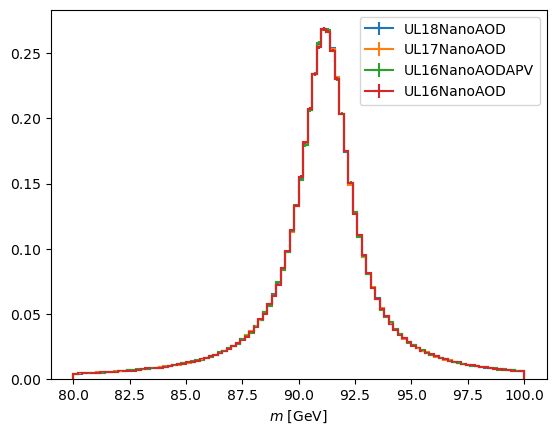

In [20]:
output['mz_gen'].stack("dataset").project("mass").plot(density=True)
plt.legend()
plt.show()

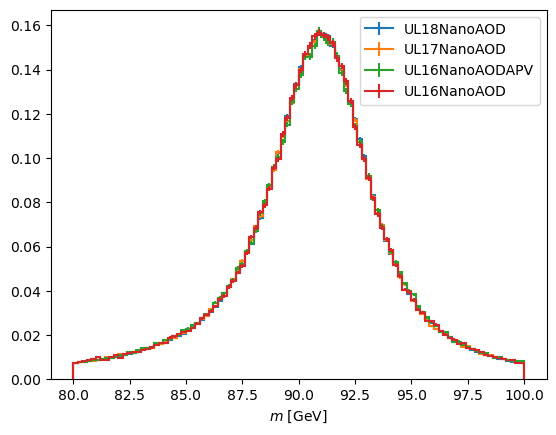

In [21]:
output['mz_reco'].stack("dataset").project("mass").plot(density=True)
plt.legend()
plt.show()

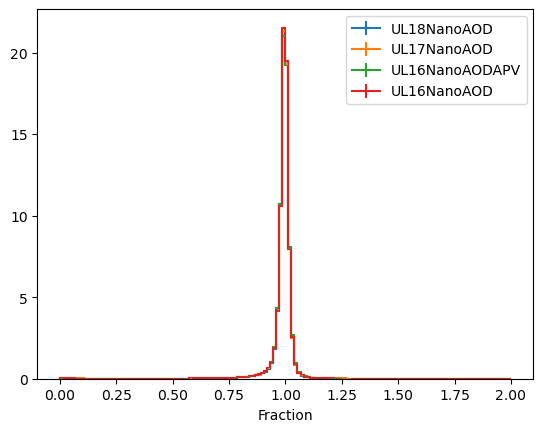

In [22]:
output['mz_reco_over_gen'].stack("dataset").project("frac").plot(density=True)
plt.legend()
plt.show()

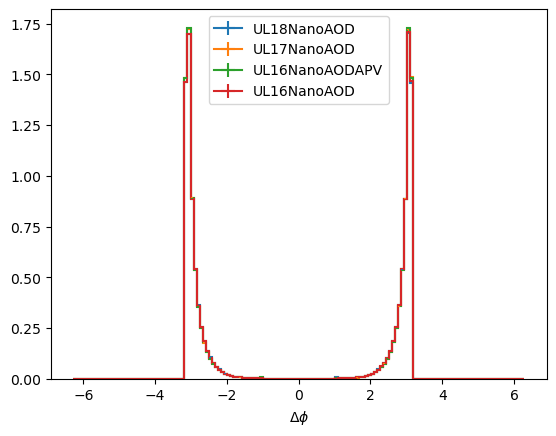

In [23]:
output['dphi_z_jet_gen'].stack("dataset").project("dphi").plot(density=True)
plt.legend()
plt.show()

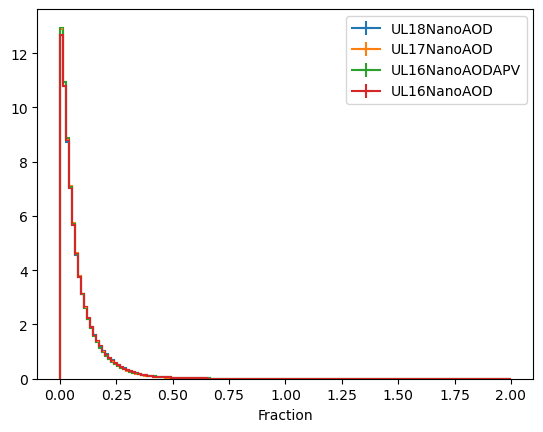

In [24]:
output['ptasym_z_jet_gen'].stack("dataset").project("frac").plot(density=True)
plt.legend()
plt.show()

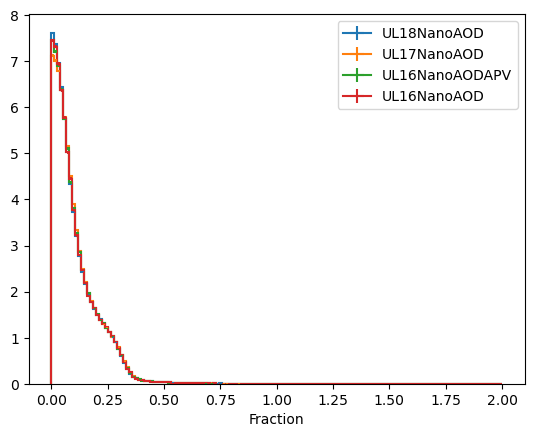

In [25]:
output['ptasym_z_jet_reco'].stack("dataset").project("frac").plot(density=True)
plt.legend()
plt.show()

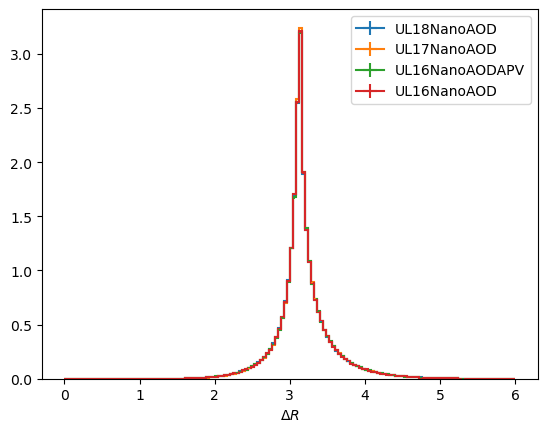

In [26]:
output['dr_z_jet_gen'].stack("dataset").project("dr").plot(density=True)
plt.legend()
plt.show()

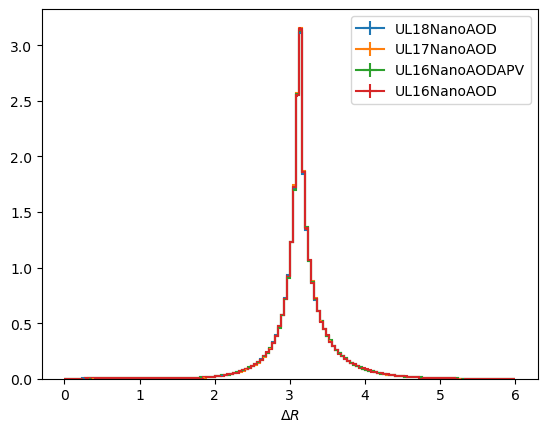

In [27]:
output['dr_z_jet_reco'].stack("dataset").project("dr").plot(density=True)
plt.legend()
plt.show()

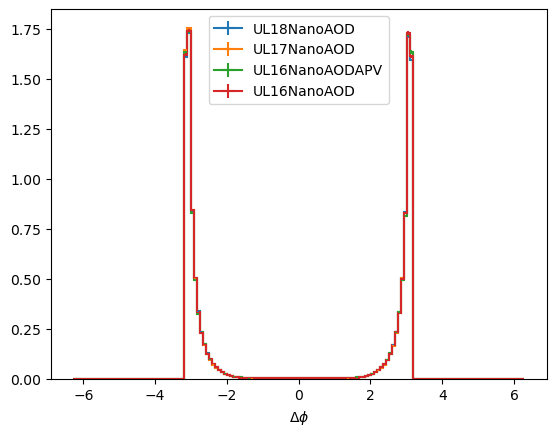

In [28]:
output['dphi_z_jet_reco'].stack("dataset").project("dphi").plot(density=True)
plt.legend()
plt.show()

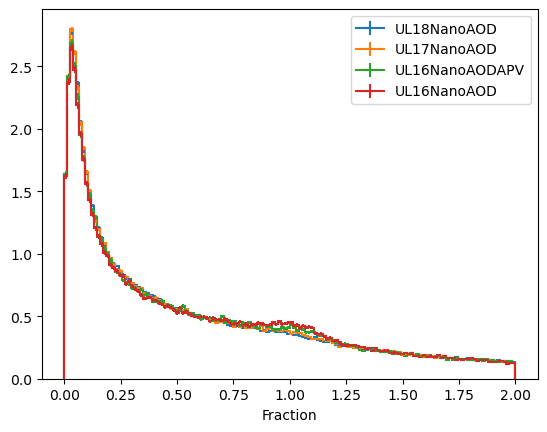

In [29]:
output['mjet_reco_over_gen'].stack("dataset").project("frac").plot(density=True)
plt.legend()
plt.show()

In [30]:
import pickle

In [31]:
with open("qjetmass_zjets.pkl", "wb") as f:
    pickle.dump( output, f )